#**1. Data Preparations 🗃️**

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/content/cleaned_dataset.csv')

In [3]:
df.shape

(2797, 2)

In [4]:
df.head()

,review_text,sentiment
0,this was our first trip to new york so i was u...,Positive
1,stayed nights at the affinia manhatten in a st...,Positive
2,we stayed at the affinia from the rd to the th...,Positive
3,we loved this hotel the room was great we had ...,Positive
4,my teenage daughter and i stayed one night we ...,Positive


In [5]:
df["sentiment"].value_counts()

,count
sentiment,
Positive,975
Neutral,919
Negative,903


In [6]:
!pip install torch
!pip install transformers
!pip install optuna
import transformers
import torch
import pandas as pd
import tqdm.notebook as tqdm
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


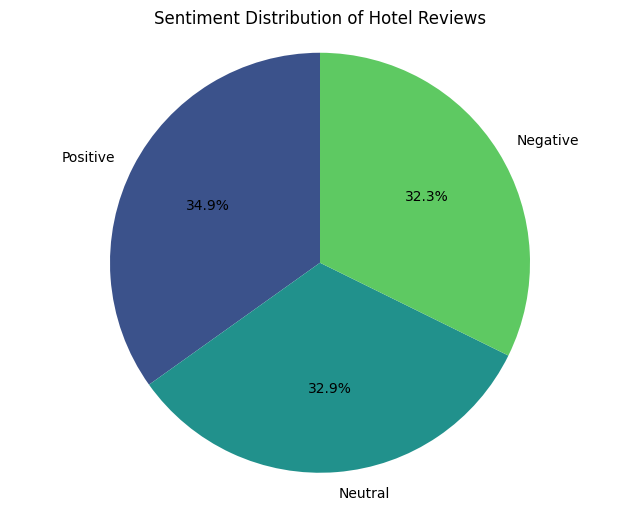

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(sentiment_counts)))


plt.title('Sentiment Distribution of Hotel Reviews')
plt.axis('equal')

plt.show()

In [8]:
# convert sentiment labels into numercal values ( label encoding before inputing it into bert)
possible_labels = df['sentiment'].unique()  #list that conatin all-of the labels

label_dict = {} # Creating an empty Dict, & Looping over the possible labels
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

label_dict

{'Positive': 0, 'Negative': 1, 'Neutral': 2}

In [9]:
df['label'] = df['sentiment'].replace(label_dict)

<ipython-input-9-6b0484cbca71>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['sentiment'].replace(label_dict)


In [10]:
df.head()

,review_text,sentiment,label
0,this was our first trip to new york so i was u...,Positive,0
1,stayed nights at the affinia manhatten in a st...,Positive,0
2,we stayed at the affinia from the rd to the th...,Positive,0
3,we loved this hotel the room was great we had ...,Positive,0
4,my teenage daughter and i stayed one night we ...,Positive,0


In [11]:
from sklearn.model_selection import train_test_split
# First split: Train 60% and Temp (Validation + Test) 40%
train_df, temp_df = train_test_split(df,
                                     test_size=0.4,  # 40% of the dataset for validation + test
                                     stratify=df['label'],# Maintain label distribution
                                     random_state=42)

# Second split: Split Temp into Validation (20%) and Test (20%)
val_df, test_df = train_test_split(temp_df,
                                   test_size=0.5,# 50% of the temp set (40% * 0.5 = 20% of the total data)
                                   stratify=temp_df['label'],# Maintain label distribution
                                   random_state=42)

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")
def tokenize_function(examples):
    return tokenizer(examples['review_text'], padding='max_length', truncation=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00


In [14]:
import transformers
from datasets import Dataset
# Converts the pandas DataFrames into Hugging Face Dataset objects, so it can be used with Trainer
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [15]:
# apply tokenization function to generate word embeddings of each review
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1678 [00:00<?, ? examples/s]

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

In [16]:
#Remove unnecessary columns (cleaned_text and index columns) from the dataset to avoid any issues during training.
train_dataset = train_dataset.remove_columns(['review_text', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['review_text', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['review_text', '__index_level_0__'])

In [17]:
#Converts datasets into PyTorch format, making them compatible with BERT (which is typically trained using PyTorch).
train_dataset.set_format('torch')
val_dataset.set_format('torch')
test_dataset.set_format('torch')

#**2. Model Fine-Tuning 🛠️**

In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute Accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Compute Confusion Matrix (optional, for detailed class-wise performance)
    cm = confusion_matrix(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [19]:
# Objective function for hyperparameter tuning with Optuna
import gc
import torch

def objective(trial):
    # Define the search space for hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 4)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]) # Reduced batch sizes

    # Initialize the model
    model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilroberta-base", num_labels=3)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",   # Evaluate at the end of each epoch
        save_strategy="epoch",         # Save the model at the end of each epoch to match evaluation strategy
        save_total_limit=2,            # Keep only the 2 best models
        load_best_model_at_end=True,   # Load the best model at the end
        fp16=True,  # Enable mixed precision training to reduce memory usage
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    eval_results = trainer.evaluate(val_dataset)

    # Clear cache and garbage collect after each trial to free up memory
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()

    # Return the evaluation loss as the objective metric
    return eval_results["eval_loss"]

In [20]:
# Run the hyperparameter tuning with Optuna
import optuna
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=10)  # Try 10 different hyperparameter configurations

[I 2024-10-26 00:12:19,320] A new study created in memory with name: no-name-4e0e8b09-d722-400d-aa6f-f40f735c82b9


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a di

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.007700,0.003723,1.000000,1.000000,1.000000,1.000000
2,0.000900,0.000499,1.000000,1.000000,1.000000,1.000000


[I 2024-10-26 00:14:21,402] Trial 0 finished with value: 0.0004992851754650474 and parameters: {'learning_rate': 2.4840302859730644e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.909400,0.748647,0.887299,0.896696,0.887299,0.886252
2,0.020300,0.010364,1.000000,1.000000,1.000000,1.000000
3,0.004300,0.002618,1.000000,1.000000,1.000000,1.000000


[I 2024-10-26 00:16:17,292] Trial 1 finished with value: 0.002617528894916177 and parameters: {'learning_rate': 1.4051032972280408e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.252700,0.002203,0.998211,0.998221,0.998211,0.998211
2,0.000200,0.015757,0.998211,0.998221,0.998211,0.998211
3,0.000100,0.015074,0.998211,0.998221,0.998211,0.998211
4,0.000100,0.012157,0.996422,0.996422,0.996422,0.996422


[I 2024-10-26 00:19:46,607] Trial 2 finished with value: 0.0022025620564818382 and parameters: {'learning_rate': 3.5813922015685966e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.725700,0.577882,0.898032,0.899100,0.898032,0.897862
2,0.005100,0.008025,0.998211,0.998221,0.998211,0.998211


[I 2024-10-26 00:21:05,847] Trial 3 finished with value: 0.008025050163269043 and parameters: {'learning_rate': 2.2674744779170008e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.972700,0.824815,0.856887,0.874886,0.856887,0.853915
2,0.035000,0.017781,1.000000,1.000000,1.000000,1.000000
3,0.004900,0.002627,1.000000,1.000000,1.000000,1.000000
4,0.002100,0.001634,1.000000,1.000000,1.000000,1.000000


[I 2024-10-26 00:23:38,086] Trial 4 finished with value: 0.0016339871799573302 and parameters: {'learning_rate': 1.223018070404678e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.003100,0.011156,0.998211,0.998221,0.998211,0.998211
2,0.071900,0.002490,0.998211,0.998221,0.998211,0.998211
3,0.000300,0.029320,0.996422,0.996461,0.996422,0.996422
4,0.000200,0.015547,0.998211,0.998221,0.998211,0.998211


[I 2024-10-26 00:26:28,546] Trial 5 finished with value: 0.0024904392194002867 and parameters: {'learning_rate': 3.426625860286405e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.011300,0.007070,0.998211,0.998221,0.998211,0.998211
2,0.001000,0.007695,0.998211,0.998221,0.998211,0.998211
3,0.000500,0.009408,0.998211,0.998221,0.998211,0.998211
4,0.000400,0.001637,0.998211,0.998221,0.998211,0.998211


[I 2024-10-26 00:29:19,140] Trial 6 finished with value: 0.001636854256503284 and parameters: {'learning_rate': 1.824561277710873e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `t

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000700,0.020898,0.996422,0.996461,0.996422,0.996422
2,0.000200,0.053728,0.992844,0.992882,0.992844,0.992844


[I 2024-10-26 00:31:07,052] Trial 7 finished with value: 0.020897768437862396 and parameters: {'learning_rate': 4.3364448909205774e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.755300,0.632015,0.919499,0.926949,0.919499,0.918988
2,0.009500,0.006110,1.000000,1.000000,1.000000,1.000000
3,0.002500,0.001709,1.000000,1.000000,1.000000,1.000000
4,0.001400,0.016619,0.994633,0.994643,0.994633,0.994633


[I 2024-10-26 00:33:39,443] Trial 8 finished with value: 0.0017093836795538664 and parameters: {'learning_rate': 1.8976202118127122e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.0004992851754650474.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.031100,0.022981,0.994633,0.994719,0.994633,0.994632
2,0.000700,0.004872,0.998211,0.998221,0.998211,0.998211


[I 2024-10-26 00:35:07,953] Trial 9 finished with value: 0.00487211998552084 and parameters: {'learning_rate': 2.774887984125061e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.0004992851754650474.


In [21]:
# 7. Print best hyperparameters
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 2.4840302859730644e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8}


In [22]:
# 8. Train the final model with the best hyperparameters
best_params = study.best_params

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=best_params['learning_rate'],
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=16,
    warmup_steps=150,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",   # Evaluate at the end of each epoch
    save_strategy="epoch",         # Save the model at the end of each epoch to match evaluation strategy
    save_total_limit=2,            # Keep only the 2 best models
    load_best_model_at_end=True, # Load the best model at the end

)


# Initialize the model with best hyperparameters
final_model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilroberta-base", num_labels=3)


# Initialize Trainer with the best hyperparameters
trainer = Trainer(
    model=final_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train and save the final model
trainer.train()
trainer.save_model('./best_fine_tuned_distilroberta')
tokenizer.save_pretrained('./best_fine_tuned_distilroberta')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.040581,0.992844,0.992997,0.992844,0.992843
2,No log,0.018960,0.996422,0.996422,0.996422,0.996422


('./best_fine_tuned_distilroberta/tokenizer_config.json',
 './best_fine_tuned_distilroberta/special_tokens_map.json',
 './best_fine_tuned_distilroberta/vocab.json',
 './best_fine_tuned_distilroberta/merges.txt',
 './best_fine_tuned_distilroberta/added_tokens.json',
 './best_fine_tuned_distilroberta/tokenizer.json')

In [23]:
# 9. Evaluate the final model on the test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.01974879391491413, 'eval_accuracy': 0.9964285714285714, 'eval_precision': 0.9964676034348164, 'eval_recall': 0.9964285714285714, 'eval_f1': 0.9964286250439646, 'eval_runtime': 3.3081, 'eval_samples_per_second': 169.28, 'eval_steps_per_second': 10.58, 'epoch': 2.0}


In [24]:
# Load the best fine-tuned model and tokenizer
model_path = '/content/best_fine_tuned_distilroberta'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
# Set the model to evaluation mode
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

#**3. Evaluation 🔍**

In [25]:
# Example text for inference
texts = [
    "The hotel was amazing and the staff was very friendly!",
    "The room was dirty and the service was terrible."
]

# Tokenize the input text
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Move inputs to the correct device (if using GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

In [26]:
# Perform inference
with torch.no_grad():  # Disable gradient computation for inference
    outputs = model(**inputs)
    logits = outputs.logits

# Get the predicted class for each input
predicted_classes = torch.argmax(logits, dim=1)

# Convert predicted class indices to labels (0=Positive, 1=Negative, 2=Neutral)
label_map = {0: "Positive", 1: "Negative", 2: "Neutral"}
predicted_labels = [label_map[pred.item()] for pred in predicted_classes]

# Print results
for text, label in zip(texts, predicted_labels):
    print(f"Text: {text}\nPredicted Sentiment: {label}\n")

Text: The hotel was amazing and the staff was very friendly!
Predicted Sentiment: Neutral

Text: The room was dirty and the service was terrible.
Predicted Sentiment: Negative

